This notebook shows how to run and compare different reservoirs.

**Timings are currently off due to not having jitted everything yet.**

In [8]:
from jacho.layers.reservoirs import RandomReservoir, StructuredTransform, FastStructuredTransform, SparseReservoir
from jacho.models.generic import GenericEchoState
from jacho.layers.output import Residual
from jacho.training.training import ridge
from jacho.data.KS import KS

from jax import random
import numpy as np
import jax.numpy as jnp
from jax import jit
from flax import linen as nn

import matplotlib.pyplot as plt

key = random.PRNGKey(42)

# Making data

In [2]:
# Setting up our dataset; similar to jonathans
L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 2000
N_init = 1000  # remove the initial points
tend = (N_train + N_test) * dt + N_init

np.random.seed(1)
dns = KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()

In [3]:
# Prepping train and test matrices
# inputs need to be size [time_steps, samples, spatial_points]
# i.e. here they are [10000, 1, 100]
u = np.expand_dims(dns.uu, axis=1)
_, u_train, u_test, _ = np.split(u / np.sqrt(N), 
                                     [N_init, 
                                     (N_init + N_train), 
                                     (N_init + N_train + N_test)], axis=0)

# Random reservoir

First one is a fully connected random reservoir:

In [4]:
# Setting up random model
n_reservoir = 10000
reservoir_args = (0.4, 0.9, 0.4) #input_scale, reservoir_scale, bias_scale

n_out = u_train.shape[-1]
norm_factor = 1.1 * jnp.sqrt(n_out / n_reservoir)
output_layer_args = (norm_factor, )

model = GenericEchoState(n_reservoir, RandomReservoir, reservoir_args,
                  n_out, Residual, output_layer_args)



state = model.initialize_state(key, n_reservoir)
params = model.init(key, state, u_train[0]) # initializing the parameters and state

In [5]:
# Running reservoir
new_state, intermediate_states = model.apply(params, state, u_train, method=model.run_reservoir)

In [6]:
%%timeit
# its been compiled in the background -  no need for jit when timing but run once before timing and block_until_ready() is important
model.apply(params, state, u_train, method=model.run_reservoir)[0].block_until_ready()

10.3 s ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
# Training - as also runs the reservoir! Should be able to easily change if you want to
end_of_train_state, params = ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2, n_init=50)

In [8]:
%%timeit
ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2, n_init=50)[0].block_until_ready()

10.4 s ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# Predicting
n_predict_steps = 2000
end_of_predict_state, (prediction, _) = model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)

In [10]:
%%timeit
model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)[1][0].block_until_ready()

2.17 s ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


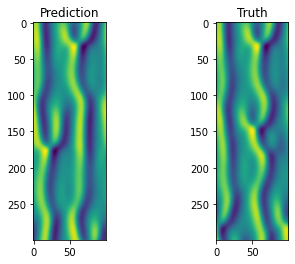

In [11]:
plt.subplot(121)
plt.title('Prediction')
plt.imshow(prediction.squeeze()[:300])

plt.subplot(122)
plt.title('Truth')
plt.imshow(u_test.squeeze()[:300])

# Slow structured prediction

In [5]:
# Setting up random model
n_reservoir = 5000
reservoir_args = (0.4, 0.9, 0.4) #input_scale, reservoir_scale, bias_scale

n_out = u_train.shape[-1]
norm_factor = 1.1 * jnp.sqrt(n_out / n_reservoir)
output_layer_args = (norm_factor, )

model = GenericEchoState(n_reservoir, StructuredTransform, reservoir_args,
                  n_out, Residual, output_layer_args)



state = model.initialize_state(key, n_reservoir)
params = model.init(key, state, u_train[0]) # initializing the parameters and state

In [6]:
# Running reservoir
new_state, intermediate_states = model.apply(params, state, u_train, method=model.run_reservoir)

In [ ]:
# Training - currently runs the reservoir as well but should change.
end_of_train_state, params = ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2)

In [ ]:
# Predicting
n_predict_steps = 2000
end_of_predict_state, (prediction, _) = model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)

In [ ]:
plt.subplot(121)
plt.title('Prediction')
plt.imshow(prediction.squeeze()[:300])

plt.subplot(122)
plt.title('Truth')
plt.imshow(u_test.squeeze()[:300])

# Fast Structured prediction

In [21]:
# Setting up random model
n_reservoir = 8192
reservoir_args = (0.4, 0.9, 0.4) #input_scale, reservoir_scale, bias_scale

n_out = u_train.shape[-1]
norm_factor = 1.1 * jnp.sqrt(n_out / n_reservoir)
output_layer_args = (norm_factor, )

model = GenericEchoState(n_reservoir, FastStructuredTransform, reservoir_args,
                  n_out, Residual, output_layer_args)



state = model.initialize_state(key, n_reservoir)
params = model.init(key, state, u_train[0]) # initializing the parameters and state

In [22]:
# Running reservoir
new_state, intermediate_states = model.apply(params, state, u_train, method=model.run_reservoir)

In [23]:
# Training - currently runs the reservoir as well but should change.
end_of_train_state, params = ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2)

In [24]:
# Predicting
n_predict_steps = 2000
end_of_predict_state, (prediction, _) = model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)

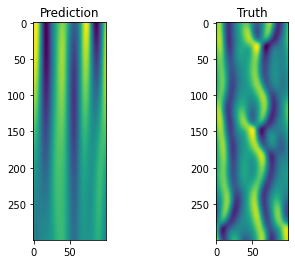

In [25]:
plt.subplot(121)
plt.title('Prediction')
plt.imshow(prediction.squeeze()[:300])

plt.subplot(122)
plt.title('Truth')
plt.imshow(u_test.squeeze()[:300])

Okay there's an error here somewhere....

# Sparse 

In [4]:
# Setting up sparse model model
n_reservoir = 10000
reservoir_args = (0.8, 0.4, 0.9, 0.4) #sparsity level, input_scale, reservoir_scale, bias_scale

n_out = u_train.shape[-1]
norm_factor = 1.1 * jnp.sqrt(n_out / n_reservoir)
output_layer_args = (norm_factor, )

model = GenericEchoState(n_reservoir, SparseReservoir, reservoir_args,
                  n_out, Residual, output_layer_args)

state = model.initialize_state(key, n_reservoir)
params = model.init(key, state, u_train[0]) # initializing the parameters and state

In [17]:
# Running reservoir
new_state, intermediate_states = model.apply(params, state, u_train, method=model.run_reservoir)

In [18]:
# Training - currently runs the reservoir as well but should change.
end_of_train_state, params = ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2)

In [19]:
# Predicting
n_predict_steps = 2000
end_of_predict_state, (prediction, _) = model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)

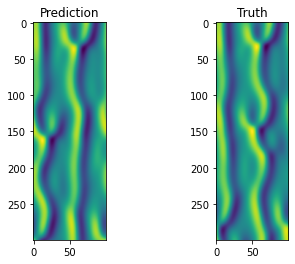

In [20]:
plt.subplot(121)
plt.title('Prediction')
plt.imshow(prediction.squeeze()[:300])

plt.subplot(122)
plt.title('Truth')
plt.imshow(u_test.squeeze()[:300])

There's an error here too....

# Recurrent kernel

In [9]:
from jacho.recurrent_kernel import RecurrentKernel, erf_kernel, train

In [10]:
model = RecurrentKernel(erf_kernel, 50, 0.11, (0.4, 0.9, 0.4))
key = random.PRNGKey(42)
params = model.init(key, u_train.squeeze())

In [17]:
# forward pass to get kernel etc
model.apply(params, u_train.squeeze(), method=model.train_kernel);

In [18]:
model_state = train(model, params, u_train.squeeze(), alpha=1e-2)

In [19]:
prediction = model.apply(params, u_train.squeeze(), model_state, length=2000, method=model.predict)

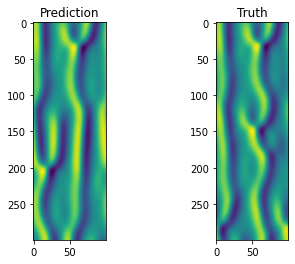

In [20]:
plt.subplot(121)
plt.title('Prediction')
plt.imshow(prediction.squeeze()[:300])

plt.subplot(122)
plt.title('Truth')
plt.imshow(u_test.squeeze()[:300])